<a href="https://colab.research.google.com/github/LazyThinkName/Road_Sign_Recognition/blob/main/TSR_SSD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import tensorflow as tf
import os
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import numpy as np
import seaborn as sns
from sklearn.preprocessing import label_binarize

In [5]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [6]:
from google.colab import drive
drive.mount('/content/drive')

# Unzip dataset (assume you uploaded it to /content/drive/MyDrive/road_sign_dataset.zip)
import zipfile
zip_path = "/content/drive/MyDrive/road_sign_dataset.zip"
extract_path = "/content/road_signs"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

Mounted at /content/drive


In [7]:
base_dir = "/content/road_signs/images"
split_base = "/content/road_signs_split"
os.makedirs(split_base, exist_ok=True)

for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join(split_base, split), exist_ok=True)

for class_name in os.listdir(base_dir):
    class_dir = os.path.join(base_dir, class_name)
    if not os.path.isdir(class_dir):
        continue

    images = [f for f in os.listdir(class_dir) if f.endswith('.jpg')]
    train_imgs, testval_imgs = train_test_split(images, test_size=0.2, random_state=42)
    val_imgs, test_imgs = train_test_split(testval_imgs, test_size=0.5, random_state=42)

    for split, split_imgs in zip(['train', 'val', 'test'], [train_imgs, val_imgs, test_imgs]):
        split_class_dir = os.path.join(split_base, split, class_name)
        os.makedirs(split_class_dir, exist_ok=True)
        for img in split_imgs:
            shutil.copy(os.path.join(class_dir, img), os.path.join(split_class_dir, img))

In [9]:

img_size = (224, 224)  # for SSD MobileNetV2 input
batch_size = 32

# train_ds = tf.keras.utils.image_dataset_from_directory(
#     "/content/road_signs_split/train",
#     image_size=img_size,
#     batch_size=batch_size,
#     label_mode='categorical'
# )

# val_ds = tf.keras.utils.image_dataset_from_directory(
#     "/content/road_signs_split/val",
#     image_size=img_size,
#     batch_size=batch_size,
#     label_mode='categorical'
# )

# test_ds = tf.keras.utils.image_dataset_from_directory(
#     "/content/road_signs_split/test",
#     image_size=img_size,
#     batch_size=batch_size,
#     label_mode='categorical'
# )

# Prefetch for performance
# AUTOTUNE = tf.data.AUTOTUNE
# train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
# val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
# test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

train_ds_raw = tf.keras.utils.image_dataset_from_directory(
    "/content/road_signs_split/train",
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

class_names = train_ds_raw.class_names  # ✅ Extract before prefetch

# Now apply prefetch
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds_raw.prefetch(buffer_size=AUTOTUNE)

# Repeat for val and test
val_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/road_signs_split/val",
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
).prefetch(AUTOTUNE)

test_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/road_signs_split/test",
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
).prefetch(AUTOTUNE)

Found 4960 files belonging to 124 classes.
Found 620 files belonging to 124 classes.
Found 620 files belonging to 124 classes.


In [10]:

num_classes = len(class_names)

base_model = tf.keras.applications.MobileNetV2(
    input_shape=img_size + (3,),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze base model

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 124)            │       158,844 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,416,828 (9.22 MB)

 Trainable params: 158,844 (620.48 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [11]:
# Add EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Train model
epochs = 30
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stop]
)

Epoch 1/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 28s 111ms/step - accuracy: 0.1176 - loss: 4.3473 - val_accuracy: 0.4790 - val_loss: 2.2696
Epoch 2/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 0.5280 - loss: 1.9894 - val_accuracy: 0.6210 - val_loss: 1.6943
Epoch 3/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - accuracy: 0.6642 - loss: 1.3978 - val_accuracy: 0.6516 - val_loss: 1.4170
Epoch 4/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.7446 - loss: 1.0949 - val_accuracy: 0.6935 - val_loss: 1.2582
Epoch 5/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.8083 - loss: 0.8873 - val_accuracy: 0.7145 - val_loss: 1.1320
Epoch 6/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.8464 - loss: 0.7579 - val_accuracy: 0.7355 - val_loss: 1.0555
Epoch 7/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.8746 - loss: 0.6435 - val_accuracy: 0.7323 - val_loss: 0.9969
Epoch 8/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.8918 - loss: 0.5577 - val_ac

In [12]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(test_ds)
print(f"\n✅ Test Accuracy: {test_acc:.2%}")

# Get true labels and predictions
y_true = []
y_pred = []
y_score = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))
    y_score.extend(preds)

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_score = np.array(y_score)

# Classification report
print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8198 - loss: 0.6650

✅ Test Accuracy: 80.81%
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step

📊 Classification Report:
                                                                     precision    recall  f1-score   support

        

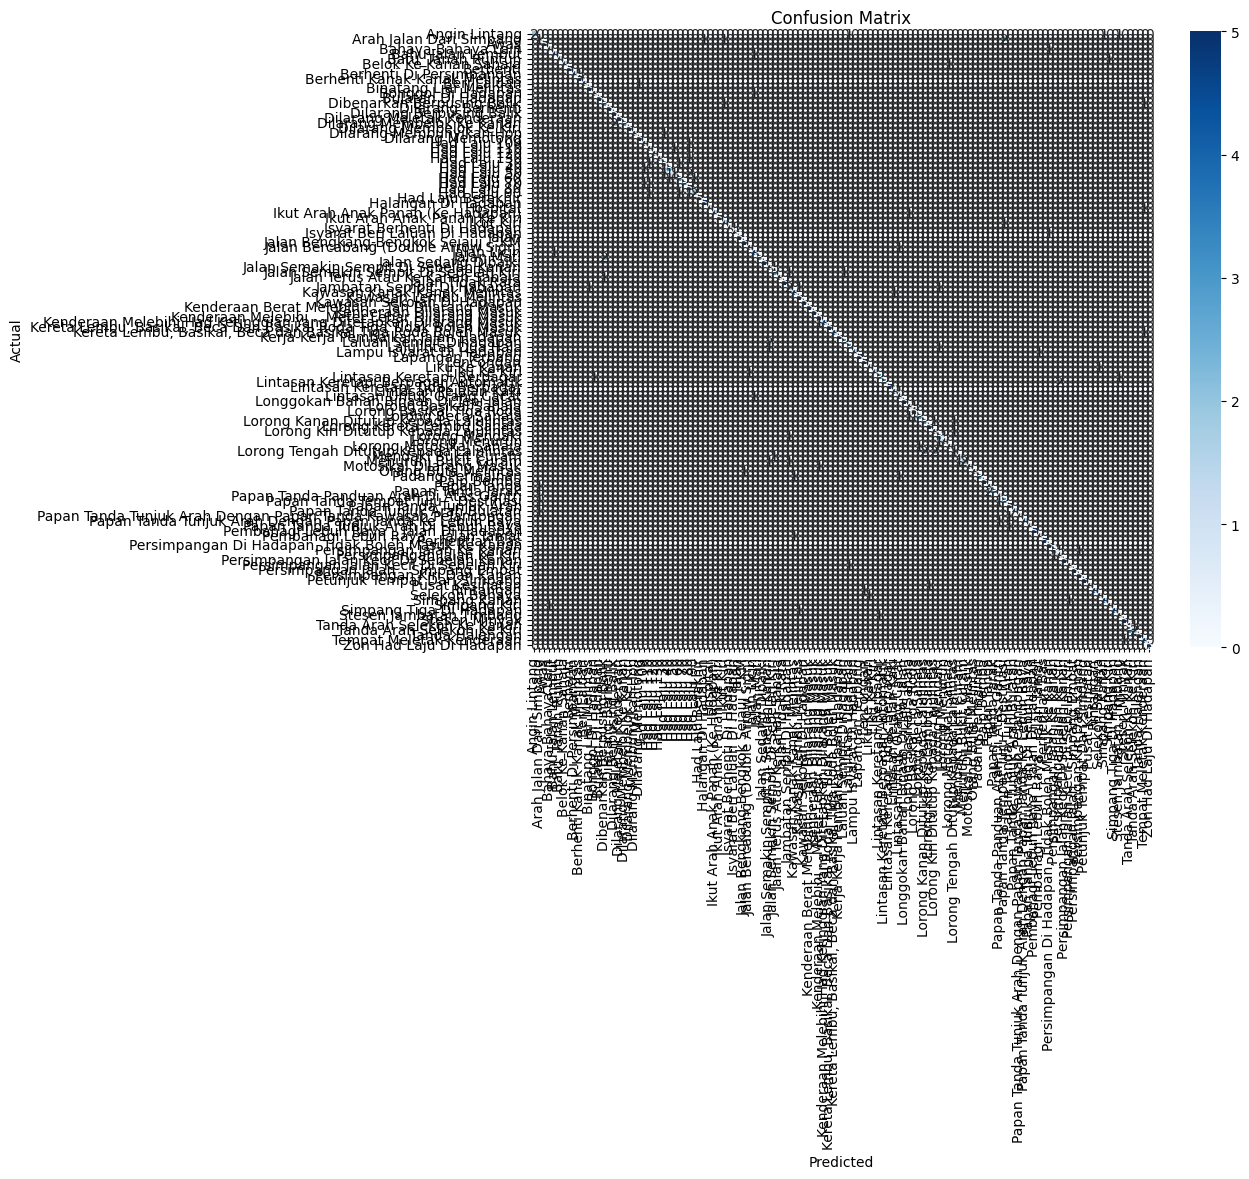

In [13]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

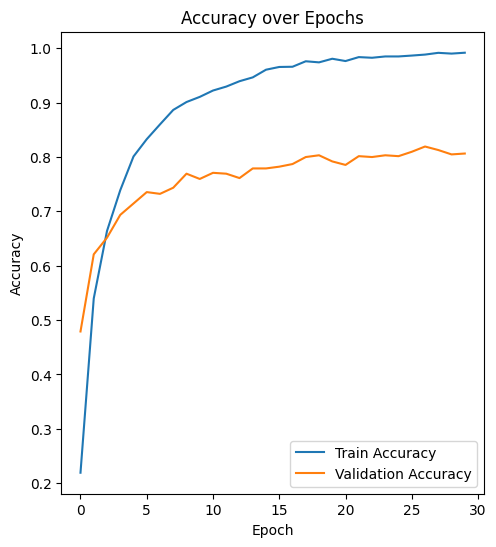

In [14]:
# Accuracy and loss plots
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

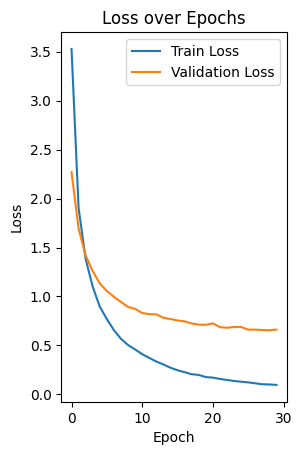

In [15]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [16]:
# Binarize y_true for multi-class ROC
y_true_bin = label_binarize(y_true, classes=list(range(len(class_names))))

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


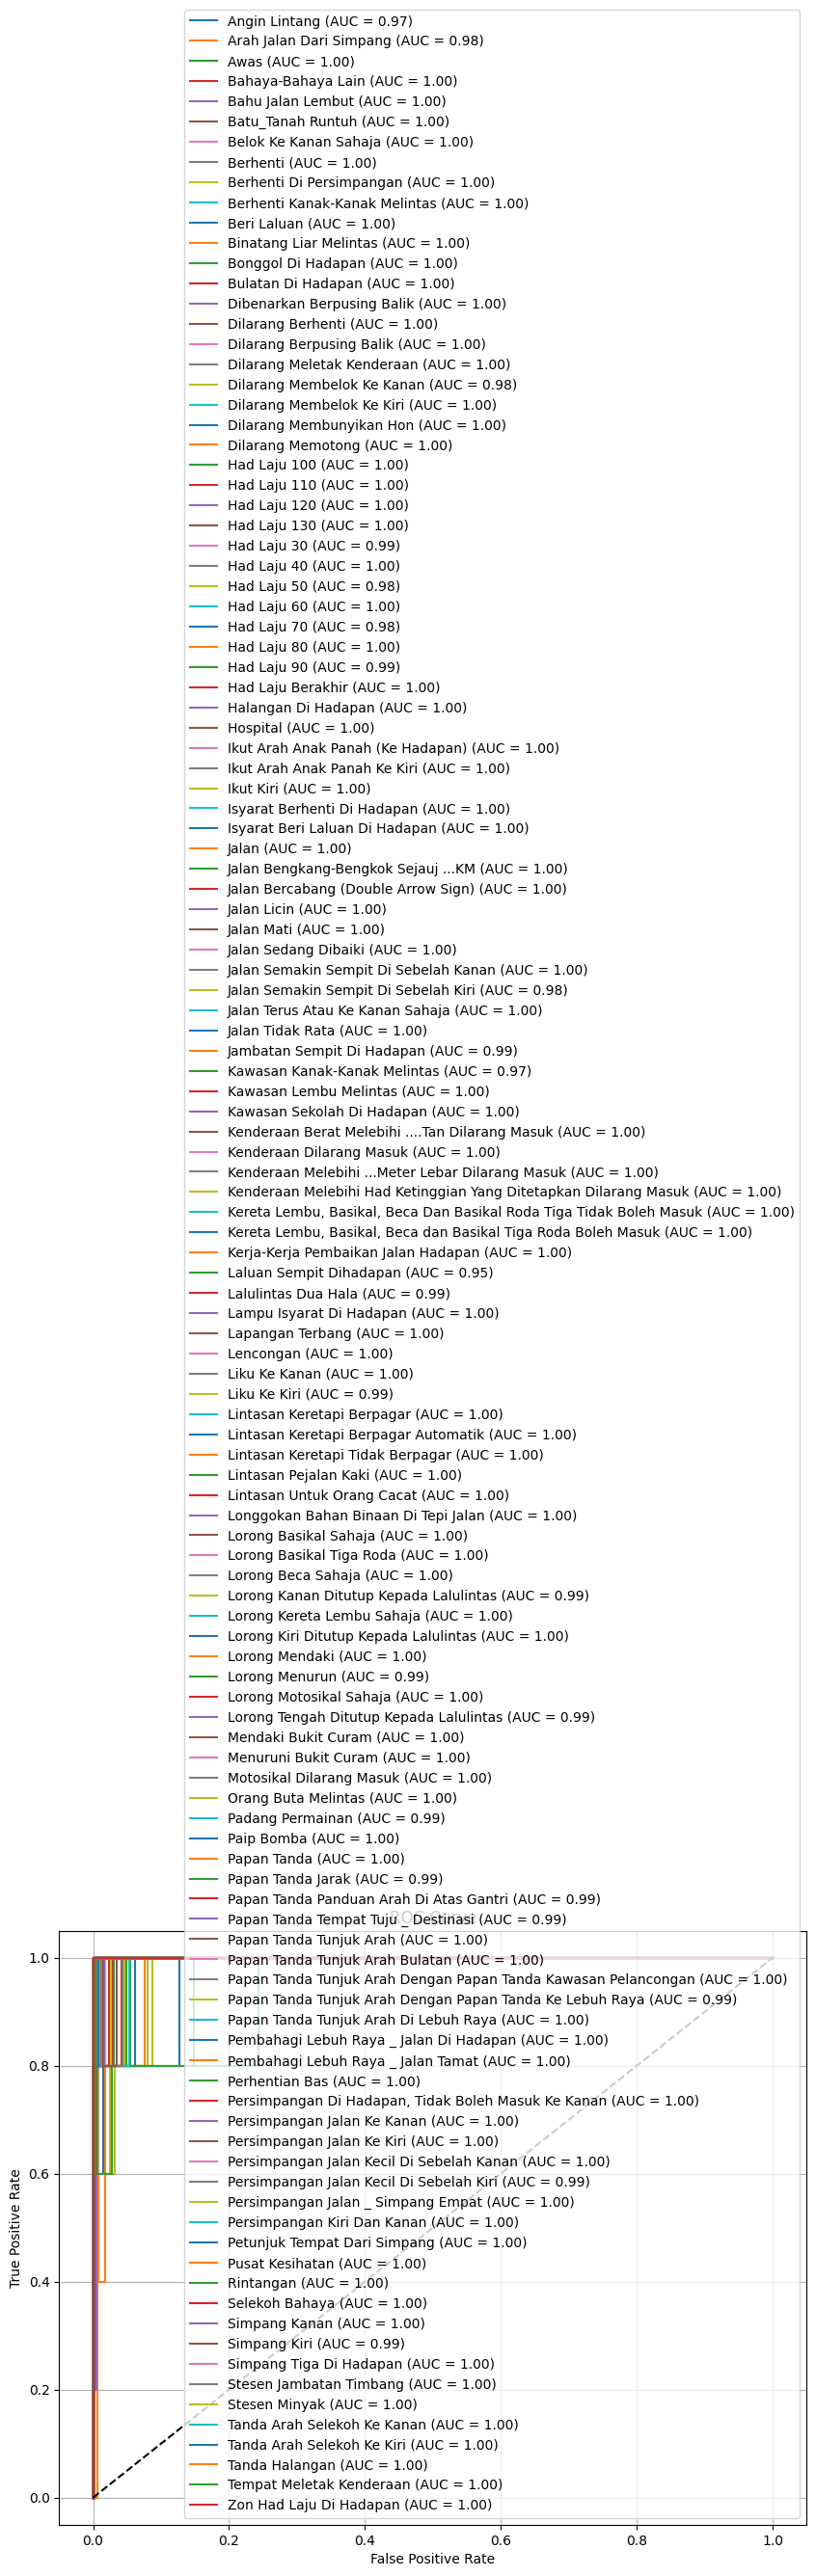

In [17]:
# Plot ROC for all classes
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [19]:
# Save Keras model
model.save('road_sign_model_SSD.h5')

# Load the .keras or .h5 model
model = tf.keras.models.load_model("road_sign_model.h5")

# Convert to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the .tflite file
with open("road_sign_model.tflite", "wb") as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmp5i7w6ozy'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 124), dtype=tf.float32, name=None)
Captures:
  132949382379088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132949382377744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132949382378128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132949382377936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132949382379280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132949382376592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132949382376976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132949382377360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132949382377168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132949382379856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13294938237

In [ ]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy:.2f}")

In [ ]:
predictions = model.predict(tf.expand_dims(img, axis=0))
predicted_class = class_names[np.argmax(predictions)]